# Additional analysis of xTea-ML classifiers

- Feature importance of all the selected models
- Multi-variate analysis of balanced accuracy/F1-score vs sample average coverage and average read length

In [47]:
# libraries for preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

# libraries for model training and evaluation
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from time import time
from sklearn.inspection import permutation_importance # for feature importance
from sklearn import linear_model # for multiple linear regression
import statsmodels.api as sm
from scipy.stats import normaltest, bartlett

## Estimate feature importance for the best performing model

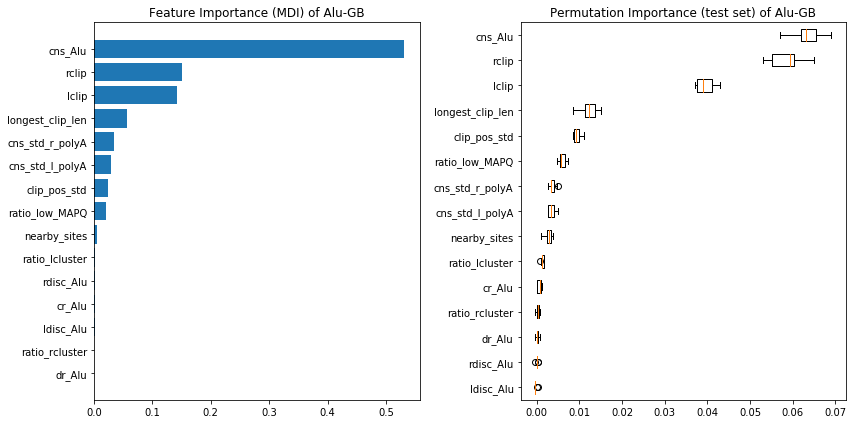

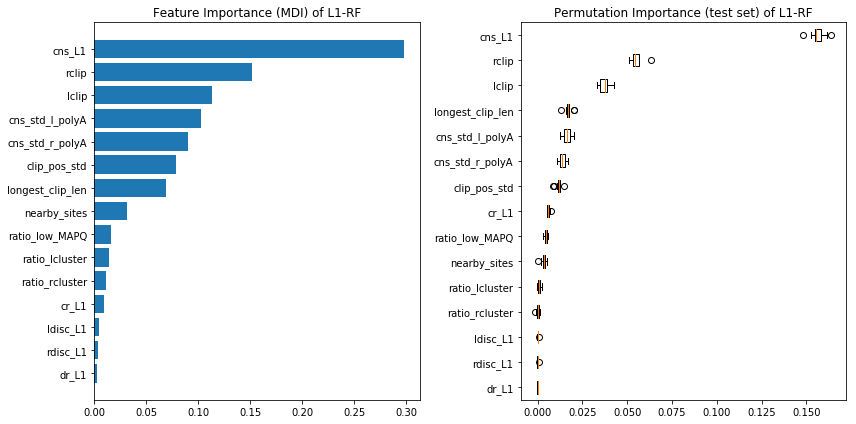

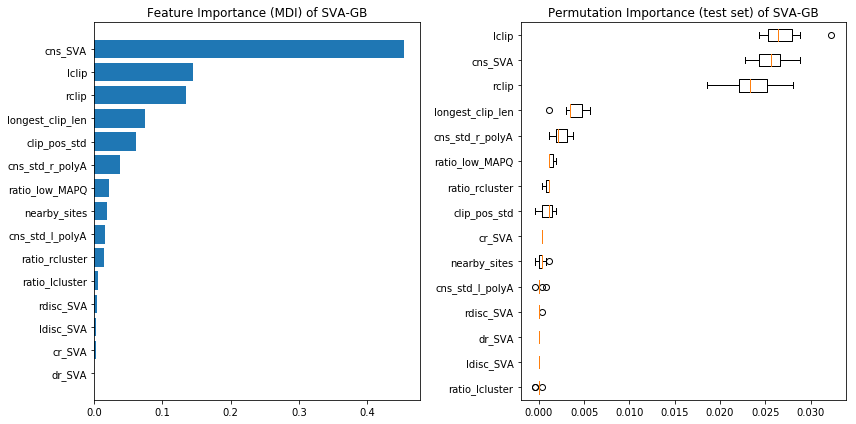

In [2]:
binary_models = [("Alu", "GB"), ("L1", "RF"), ("SVA", "GB")]
for binary_model in binary_models:
    RT, mdl = binary_model
    model = joblib.load(f'./models/{RT}_{mdl}_model.pkl')
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    X_test = pd.read_csv(f'./data/{RT}_test_features.csv')
    y_test = pd.read_csv(f'./data/{RT}_test_labels.csv')
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(list(X_test.columns))[sorted_idx])
    plt.title(f'Feature Importance (MDI) of {RT}-{mdl}')
 
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                    random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(result.importances[sorted_idx].T,
                vert=False, labels=np.array(list(X_test.columns))[sorted_idx])
    plt.title(f"Permutation Importance (test set) of {RT}-{mdl}")
    fig.tight_layout()
    plt.show()

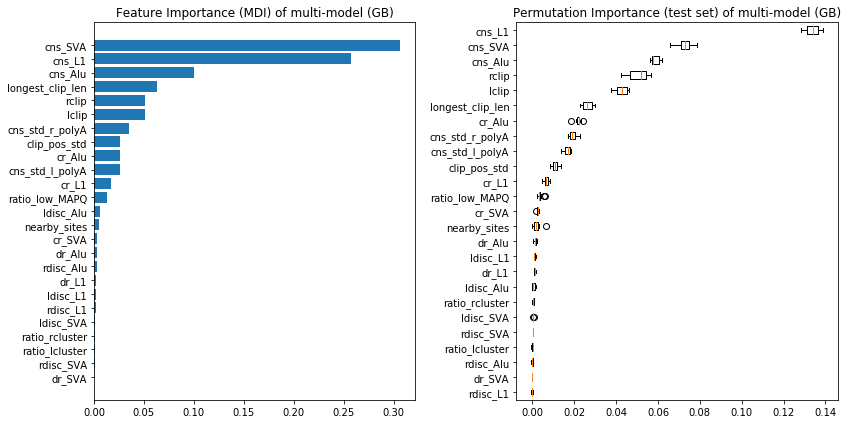

In [3]:
multi_model = joblib.load(f'./models/all_GB_model.pkl')
feature_importance = multi_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
X_test = pd.read_csv(f'./data/all_test_features.csv')
y_test = pd.read_csv(f'./data/all_test_labels.csv')
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(X_test.columns))[sorted_idx])
plt.title(f'Feature Importance (MDI) of multi-model (GB)')

result = permutation_importance(multi_model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(list(X_test.columns))[sorted_idx])
plt.title(f"Permutation Importance (test set) of multi-model (GB)")
fig.tight_layout()
plt.show()

## Balanced accuracy versus avg read length/cov

### Load chr2-unmapped test set statistics for multi- and binary- classifiers

In [15]:
multi_dir = './stats/multi/'
multi_Alu_low = pd.read_csv(multi_dir + "Alu_lowcov.tsv", index_col=0, sep="\t")
multi_L1_low = pd.read_csv(multi_dir + "L1_lowcov.tsv", index_col=0, sep="\t")
multi_SVA_low = pd.read_csv(multi_dir + "SVA_lowcov.tsv", index_col=0, sep="\t")
multi_Alu_high = pd.read_csv(multi_dir + "Alu_highcov.tsv", index_col=0, sep="\t")
multi_L1_high = pd.read_csv(multi_dir + "L1_highcov.tsv", index_col=0, sep="\t")
multi_SVA_high = pd.read_csv(multi_dir + "SVA_highcov.tsv", index_col=0, sep="\t")

binary_dir = './stats/binary/'
binary_Alu_low = pd.read_csv(binary_dir + "Alu_lowcov.tsv", index_col=0, sep="\t")
binary_L1_low = pd.read_csv(binary_dir + "L1_lowcov.tsv", index_col=0, sep="\t")
binary_SVA_low = pd.read_csv(binary_dir + "SVA_lowcov.tsv", index_col=0, sep="\t")
binary_Alu_high = pd.read_csv(binary_dir + "Alu_highcov.tsv", index_col=0, sep="\t")
binary_L1_high = pd.read_csv(binary_dir + "L1_highcov.tsv", index_col=0, sep="\t")
binary_SVA_high = pd.read_csv(binary_dir + "SVA_highcov.tsv", index_col=0, sep="\t")

multi_Alu = pd.concat([multi_Alu_low, multi_Alu_high])
multi_L1 = pd.concat([multi_L1_low, multi_L1_high])
multi_SVA = pd.concat([multi_SVA_low, multi_SVA_high])

binary_Alu = pd.concat([binary_Alu_low, binary_Alu_high])
binary_L1 = pd.concat([binary_L1_low, binary_L1_high])
binary_SVA = pd.concat([binary_SVA_low, binary_SVA_high])

In [6]:
multi_Alu_low.head()

,Corr Balanced Accu,Precision,Corr Recall,Corr F1-score
I7224,0.443,0.302,0.154,0.204
I1581,0.380,0.263,0.122,0.167
I4233,0.598,0.516,0.390,0.444
I4562,0.504,0.507,0.276,0.357
I5109,0.503,0.451,0.260,0.330


### Load sample info

In [14]:
lowcov_info = pd.read_csv("./stats/lowcov_info_v2_SE.tsv", sep="\t")
highcov_info = pd.read_csv("./stats/highcov_info_v2_SE.tsv", sep="\t")
info = pd.concat([lowcov_info, highcov_info])
info.head()

,sample,raw_total_sequences,dedup_sequences,reads_mapped_dedup,avg_read_len,avg_cov
0,I7224_1_clip2,374261851,319823642,257449496,44,3.788554
1,I1581_1_clip2,413976679,397075208,167418818,51,2.855639
2,I4233_1_clip2,438438703,387569881,350345366,49,5.741446
3,I4562_1_clip2,444669890,389954504,224384344,50,3.752247
4,I5109_1_clip2,425130802,323291266,255545720,48,4.102406


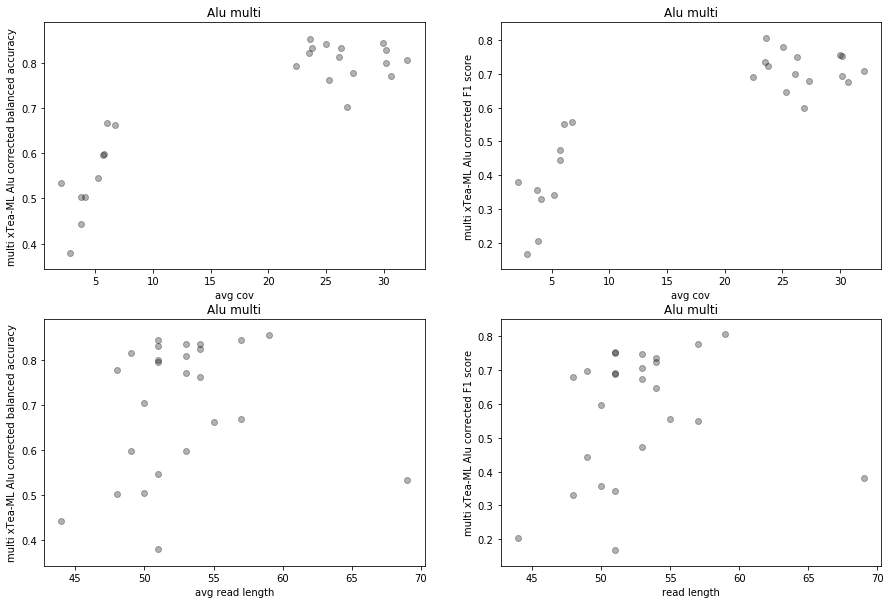

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0,0].scatter(info['avg_cov'].values, multi_Alu['Corr Balanced Accu'].values, color='black', alpha=0.3)
ax[0,0].set_xlabel('avg cov')
ax[0,0].set_ylabel('multi xTea-ML Alu corrected balanced accuracy')
ax[0,0].set_title('Alu multi')
# ax[0].legend(loc='best')
ax[0,1].scatter(info['avg_cov'].values, multi_Alu['Corr F1-score'].values, color='black', alpha=0.3)
ax[0,1].set_xlabel('avg cov')
ax[0,1].set_ylabel('multi xTea-ML Alu corrected F1 score')
ax[0,1].set_title('Alu multi')
# ax[1].legend(loc='best')
ax[1,0].scatter(info['avg_read_len'].values, multi_Alu['Corr Balanced Accu'].values, color='black', alpha=0.3)
ax[1,0].set_xlabel('avg read length')
ax[1,0].set_ylabel('multi xTea-ML Alu corrected balanced accuracy')
ax[1,0].set_title('Alu multi')
# ax[0].legend(loc='best')
ax[1,1].scatter(info['avg_read_len'].values, multi_Alu['Corr F1-score'].values, color='black', alpha=0.3)
ax[1,1].set_xlabel('read length')
ax[1,1].set_ylabel('multi xTea-ML Alu corrected F1 score')
ax[1,1].set_title('Alu multi')
# ax[1].legend(loc='best')
plt.show()

### Multivariate linear regression

Intercept: 
 0.152706257165646
Coefficients: 
 [0.01164164 0.00644813]


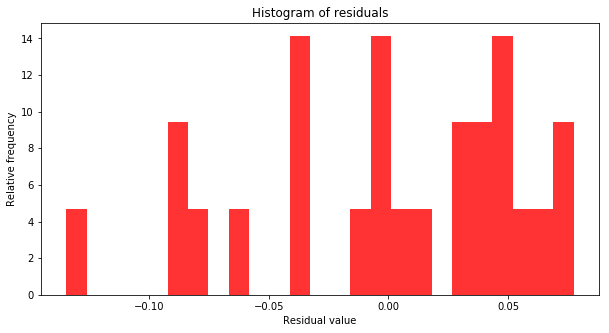

In [20]:
X = info[['avg_cov', 'avg_read_len']]
Y = multi_Alu['Corr Balanced Accu']
regr = linear_model.LinearRegression()
lr = regr.fit(X, Y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
Y_predict = regr.predict(X)
#compute residuals
residuals = Y - Y_predict

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(residuals, bins=25, density=True, color='red', alpha=0.8)
ax.set_title('Histogram of residuals')
ax.set_xlabel('Residual value')
ax.set_ylabel('Relative frequency')
plt.show()

In [37]:
print("----------------------------------------Alu-----------------------------------------")
X = info[['avg_cov', 'avg_read_len']].values
Y = multi_Alu['Corr Balanced Accu'].values
results = sm.OLS(Y, X).fit()
print(results.summary())
print("----------------------------------------L1-----------------------------------------")
X = info[['avg_cov', 'avg_read_len']].values
Y = multi_L1['Corr Balanced Accu'].values
results = sm.OLS(Y, X).fit()
print(results.summary())
print("----------------------------------------SVA-----------------------------------------")
X = info[['avg_cov', 'avg_read_len']].values
Y = multi_SVA['Corr Balanced Accu'].values
results = sm.OLS(Y, X).fit()
print(results.summary())

----------------------------------------Alu-----------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1775.
Date:                Mon, 27 Sep 2021   Prob (F-statistic):           6.30e-26
Time:                        15:37:00   Log-Likelihood:                 35.966
No. Observations:                  25   AIC:                            -67.93
Df Residuals:                      23   BIC:                            -65.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [38]:
print("---------------------------------------Alu--------------------------------------")
X = info[['avg_cov', 'avg_read_len']].values
Y = multi_Alu['Corr F1-score'].values
results = sm.OLS(Y, X).fit()
print(results.summary())
print("---------------------------------------L1--------------------------------------")
X = info[['avg_cov', 'avg_read_len']].values
Y = multi_L1['Corr F1-score'].values
results = sm.OLS(Y, X).fit()
print(results.summary())
print("---------------------------------------SVA--------------------------------------")
X = info[['avg_cov', 'avg_read_len']].values
Y = multi_SVA['Corr F1-score'].values
results = sm.OLS(Y, X).fit()
print(results.summary())

---------------------------------------Alu--------------------------------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     694.5
Date:                Mon, 27 Sep 2021   Prob (F-statistic):           2.73e-21
Time:                        15:38:13   Log-Likelihood:                 28.420
No. Observations:                  25   AIC:                            -52.84
Df Residuals:                      23   BIC:                            -50.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [41]:
print(f"std dev of cov in lowcov samples {np.std(lowcov_info['avg_cov'])}")
print(f"std dev of cov in highcov samples {np.std(highcov_info['avg_cov'])}")

std dev of cov in lowcov samples 1.431042712817772
std dev of cov in highcov samples 2.955178673722239


### MANOVA

Test for normality of the dependent variables.

In [52]:
print(normaltest(multi_Alu_high["Corr Balanced Accu"]))
print(normaltest(multi_Alu_high["Corr F1-score"]))
print(normaltest(multi_L1_high["Corr Balanced Accu"]))
print(normaltest(multi_L1_high["Corr F1-score"]))
print(normaltest(multi_SVA_high["Corr Balanced Accu"]))
print(normaltest(multi_SVA_high["Corr F1-score"]))

print(normaltest(multi_Alu_low["Corr Balanced Accu"]))
print(normaltest(multi_Alu_low["Corr F1-score"]))
print(normaltest(multi_L1_low["Corr Balanced Accu"]))
print(normaltest(multi_L1_low["Corr F1-score"]))
print(normaltest(multi_SVA_low["Corr Balanced Accu"]))
print(normaltest(multi_SVA_low["Corr F1-score"]))

NormaltestResult(statistic=6.543040265643133, pvalue=0.03794869614840224)
NormaltestResult(statistic=0.5732389267408684, pvalue=0.7507973803878013)
NormaltestResult(statistic=8.28829288108529, pvalue=0.01585696503903334)
NormaltestResult(statistic=8.347376542985591, pvalue=0.015395372965525483)
NormaltestResult(statistic=0.2803498419700059, pvalue=0.8692061796992034)
NormaltestResult(statistic=3.2589329021193967, pvalue=0.19603414003659306)
NormaltestResult(statistic=0.2064346563923927, pvalue=0.9019309371565117)
NormaltestResult(statistic=0.2831250368102909, pvalue=0.8680009078561195)
NormaltestResult(statistic=0.7353408001557531, pvalue=0.6923453410565048)
NormaltestResult(statistic=0.98370787304933, pvalue=0.6114916759091015)
NormaltestResult(statistic=0.014973350924251828, pvalue=0.9925412798849047)
NormaltestResult(statistic=2.478720409810267, pvalue=0.2895694237827974)


C:\Users\97841\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
C:\Users\97841\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
C:\Users\97841\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
C:\Users\97841\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
C:\Users\97841\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
C:\Users\97841\AppData\Roaming\Python\Python37\sit

Test for equal variance within independent variables.

In [51]:
_, p = bartlett(lowcov_info["avg_read_len"], lowcov_info["avg_cov"])
print(p)
_, p = bartlett(highcov_info["avg_read_len"], highcov_info["avg_cov"])
print(p)

0.00013016792897371665
0.8444661393461946


Thus the assumption of equal variance doesn't hold for lowcov samples and the assumption of normality doesn't hold for highcov samples. We can't apply MANOVA.